<a href="https://colab.research.google.com/github/rland93/pendsim/blob/master/notebooks/state_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
GOOGLE_COLAB = True

In [2]:
if not GOOGLE_COLAB:
    %cd ../
else:
    !pip install pendsim

In [3]:
from pendsim import sim, controller, viz, utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import HTML

# State Estimation with Unscented Kalman Filter (UKF)

State estimation is the problem of estimating the true system state from noisy, incomplete, or lower-dimensional sensor inputs. A commonly used state estimator is the Kalman Filter. Here, we will use the Unscented Kalman Filter (UKF) to estimate the state, and see the impact that improved state estimation has on control outcomes.

In [4]:
dt, t_final = 0.01, 10
# slight bump at 3s
c1, c2, c3, c4, fshift = 12, 2.0, 4, .2, 3
def force_fn(t):
    return c1 * np.sin(c2*t) * c3/(c4*np.sqrt(np.pi)) * np.exp(-((t-fshift)/c4)**2)

# slightly tipped over
pend = sim.Pendulum(4,1,3.0, initial_state=np.array([0,0,0.1,0]))

Here, we introduce a `noise_scale` to simulate gaussian noise on the system. This adds sensor noise, with a mean of the true variable value, and a variance scaled for each variable. Changing this vector scales the noise.

In [5]:
noise_scale = np.array([.1,.1,.1,.1])
simu = sim.Simulation(dt, t_final, force_fn, noise_scale=noise_scale)

Here, we have two controllers: `pid` which takes action on the raw sensor measurement, and `pid_ukf` which estimates the state, and takes action based on the estimation. 

If its estimation is good, `pid_ukf` should outperform `pid`.

The parameter `var_t` passed into `pid_ukf` is the window over which to estimate the variance of the measurements: a larger window produces a more accurate noise estimate, but is not as responsive.

In [6]:
kp, ki, kd = (100.0, 0.0, 0.1)

pid = controller.PID((kp, ki, kd))
pid_ukf = controller.PID_UKF((kp, ki, kd), pend, dt, var_t=0.25)

In [7]:
res_pid = simu.simulate(pend, pid)
res_pid_ukf = simu.simulate(pend, pid_ukf)

100%|██████████| 1000/1000 [00:02<00:00, 463.97it/s]


This generates a plot of the estimated, true, and measured values for each variable. We are most interested in $\theta$ (which is labeled t on this chart), but we also might consider the estimate of the other parameters to be important in different controllers.

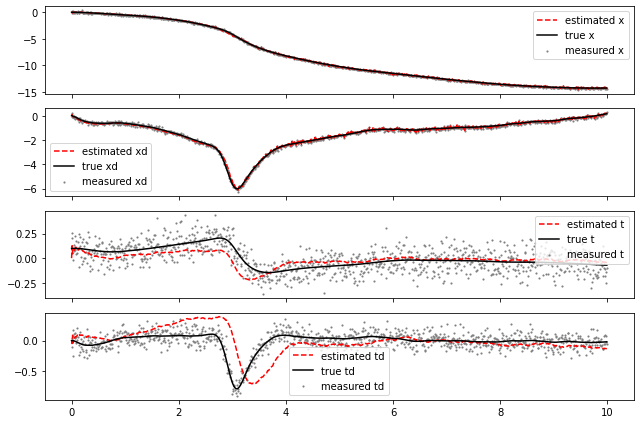

In [8]:
_, ax = plt.subplots(nrows=4, tight_layout=True, sharex=True, figsize=(9,6))
for i, (sp, su) in enumerate(zip(res_pid['state'], res_pid_ukf['state'])):
  ax[i].scatter(res_pid_ukf.index, res_pid_ukf[('measured state', su)].values, color="grey", label = 'measured ' + su, marker = '.', s=5)
  ax[i].plot(res_pid_ukf[('est', su)] , "r--",  label = 'estimated ' + su)
  ax[i].plot(res_pid_ukf[('state', su)], "k-", label = 'true ' + su)
  ax[i].legend()

We also can see the effect of filter design on performance: since the filter uses a linear model of the state to perform the estimation, the estimate can diverge, as in the $\dot{\theta}$ case. But it looks like at least for $\theta$, the estimate is pretty good.

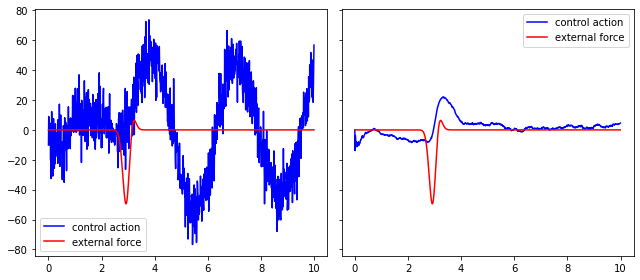

In [9]:
_, ax3 = plt.subplots(ncols=2, figsize=(9,4), tight_layout=True, sharey=True, sharex=True)
ax3[0].plot(res_pid[("control action", "control action")], 'b', label='control action')
ax3[0].plot(res_pid[("forces", "forces")], 'r', label='external force')
ax3[0].legend()
ax3[1].plot(res_pid_ukf[('control action', "control action")], 'b', label='control action')
ax3[1].plot(res_pid_ukf[('forces', 'forces')], 'r', label='external force')
ax3[1].legend()

Here, we see perhaps the clearest benefit of the state estimator: a significant reduction in actuation. Not only does the state estimator confer stability benefits, it also prevents the controller from actuating based on state noise. This means a reduction in wear, energy use, (in a physical system), etc.

Quantitatively, this means less control actuation. If we assume that the controller takes an equal amount of energy to push left as it does right, then we can estimate the energy required by taking the sum of the control actions:

In [10]:
pid_sum = np.abs(res_pid[("control action", "control action")].values).sum() / t_final
pid_ukf_sum = np.abs(res_pid_ukf[("control action", "control action")].values).sum() / t_final
print("PID Only: {}".format(round(pid_sum,2)))
print("PID with State Estimator: {}".format(round(pid_ukf_sum,2)))

PID Only: 2463.44
PID with State Estimator: 438.35


Finally, we can qualitatively see the difference in our simulation. First, the plain PID:

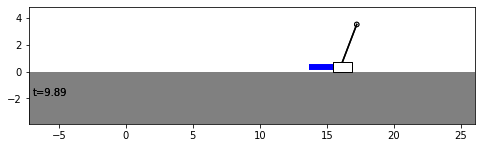

In [11]:
visu1 = viz.Visualizer(res_pid, pend, dt, speed=1)
anim1 = visu1.animate()
HTML(anim1.to_html5_video())

Then, the PID with state estimation:

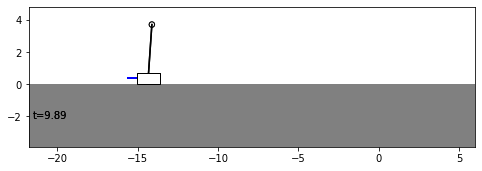

In [12]:
visu2 = viz.Visualizer(res_pid_ukf, pend, dt, speed=1)
anim2 = visu2.animate()
HTML(anim2.to_html5_video())